# Pandas Examples

In [1]:
#Input data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1) Accessing DataFrames and Series

In [2]:


# Input table (12 samples x 4 attributes)
X = np.array([[5.1, 3.5, 1, 0.2],
           [4.3, 3. , 1, 0.1],
           [5. , np.nan, 1, 0.4],
           [5.1, 3.4, 2, 0.2],
           [7.0, 3.2, 1, 0.2],
           [6.9, 3.1, 3, 1.5],
           [6.7, 3.1, 1, np.nan],
           [6. , 2.9, 2, 1.5],
           [6.1, 3. , 2, 1.4],
           [6.5, 3. , 3, 2.2],
           [7.7, 3.8, 3, 2.2],
           [7.4, 2.8, 1, 1.9],
           [6.8, 3.2, 1, 2.3]])
# Column names
columns = ['height','width','intensity','weight']

# Class label of each sample
labels = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

**a) Create a DataFrame from a Numpy array (X)**
- Setup column names and the class label
- Add a new composite feature, 'area' = 'width' * 'height'
- Fix missing values with forward fill method

In [3]:
df = pd.DataFrame(X, columns=columns)
df['area'] = df['width'] * df['height']
df['labels'] = labels                 # Setup labels
df = df.fillna(method='ffill')        # Fill missing values
df

,height,width,intensity,weight,area,labels
0,5.1,3.5,1.0,0.2,17.85,0
1,4.3,3.0,1.0,0.1,12.90,0
2,5.0,3.0,1.0,0.4,12.90,0
3,5.1,3.4,2.0,0.2,17.34,0
4,7.0,3.2,1.0,0.2,22.40,0
5,6.9,3.1,3.0,1.5,21.39,1
6,6.7,3.1,1.0,1.5,20.77,1
7,6.0,2.9,2.0,1.5,17.40,1
8,6.1,3.0,2.0,1.4,18.30,1
9,6.5,3.0,3.0,2.2,19.50,2


**b) Compute the average area of samples with intensity greater than 1:**

In [4]:
avg_area = df.loc[df['intensity']>1, 'area'].mean()
print(f"Average area (intensity>1): %.3f" % avg_area)

Average area (intensity>1): 20.532


**c) Compute the following probability:**

$$P(label=2 \ | \ height<7)$$   

In [5]:
num = ((df['labels']==2) & (df['height']<7)).sum()
den = (df['height']<7).sum()
num/den

0.2

**d) Compute the following probability. Use the Naive Bayes technique.**
$$P(label=l \ | \ intensity=2 \land height<6.5)$$

In [6]:
for l in range(3):
    l1 = (df['labels']==l).sum()
    # p(intensity=2 | label=l)
    p1 = ((df['labels']==l) & (df['intensity']==2)).sum()/l1
    # p(height<6.5 | label=l)
    p2 = ((df['labels']==l) & (df['height']<6.5)).sum()/l1
    # p(label=1)
    pl = l1/len(df)

    result = p1*p2*pl
    
    # These results are just likelihoods (not probabilities)
    # To obtain the final probabilities we should compute: result_p = p1*p2*pl/P(X)
    # However P(X) is not varying with the class l.
    # Hence this term can be removed if you just want to compare the different likelihoods 
    # obtained with different values of l
    print(f"likelihood({l}|x) = {result}")

likelihood(0|x) = 0.061538461538461556
likelihood(1|x) = 0.07692307692307693
likelihood(2|x) = 0.0


**e) Normalize columns with Sklearn standard scaler, fit a random forest**

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

clf = RandomForestClassifier(100)
clf.fit(df.drop(columns=['labels']), df['labels'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 2) Working with Pandas and spatial data
**a) Load dataframe with Points Of Interest (POIs)**

In [8]:
# This dictionary maps attributes in the table with correct data types
d_types = {'@type':str, '@lat':float, '@lon':float, 'amenity':str, 'name':str, 
           'shop':str, 'public_transport':str, 'highway':str}
# Read "./pois_all_info"
all_pois_df = pd.read_csv("pois_all_info.csv", sep='\t', index_col='@id', dtype=d_types)

In [9]:
all_pois_df.iloc[:4]

,@type,@lat,@lon,amenity,name,shop,public_transport,highway
@id,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN


**b) Plot POIS on New-York map**

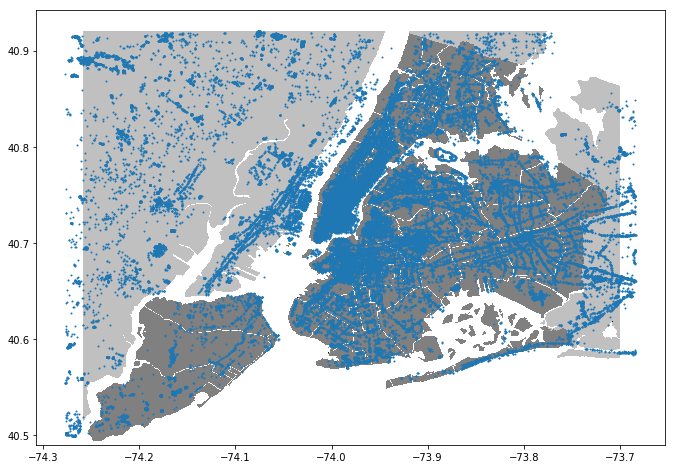

In [10]:
def plot_map(pois_df):
    fig, ax = plt.subplots(figsize=(12,8))
    nyc_img = plt.imread('./New_York_City_Map.PNG')
    ax.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92])
    ax.scatter(pois_df['@lon'], pois_df['@lat'], s=1)
    plt.show()

plot_map(all_pois_df)

**c) Filter only POIS in NY municipality**
- Plot the result on a map

In [11]:
# Read "./data/ny_municipality_pois_id.csv"
ny_pois_ids = np.loadtxt("ny_municipality_pois_id.csv")

In [12]:
pois_df = all_pois_df.loc[ny_pois_ids]

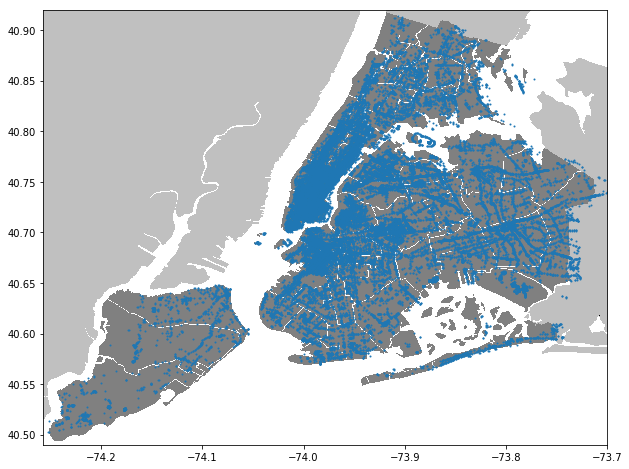

In [13]:
plot_map(pois_df)

**d) Count top-frequent public_transport types**

In [14]:
top_freq = pois_df.groupby('public_transport')['public_transport'].count().sort_values()[::-1]
top_freq

public_transport
platform         5821
stop_position    2530
station            16
stop_area           8
stop                1
Name: public_transport, dtype: int64

**e) Plot POIs with the two most frequent public transport types**

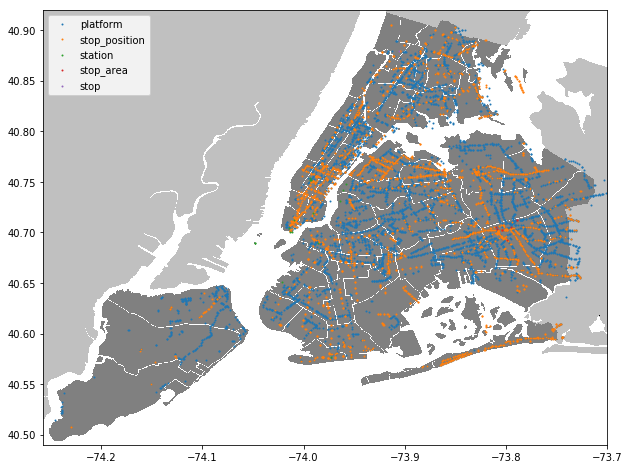

In [15]:
## Plot POIs on the map
fig, ax = plt.subplots(figsize=(12,8))
nyc_img = plt.imread('./New_York_City_Map.PNG')
ax.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92])

top_freq_names = top_freq.index
for t in top_freq_names:
    t_df = pois_df[pois_df['public_transport']==t]
    ax.scatter(t_df['@lon'], t_df['@lat'], label=t, s=1)

plt.legend()
plt.show()